In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score


2024-07-08 16:19:06.690328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 16:19:06.714301: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 16:19:06.714341: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-08 16:19:06.726462: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-08 16:19:07.514904: W tensorflow/compiler/tf

In [2]:
file_path = '/home/bhikrant07/Desktop/AI/KU_STUDENT_DATA_ON_CAMPUS_PLACEMENT.csv'
data = pd.read_csv(file_path)

print(data.head(1))

  Branch               Cepo  Program  End term exam SGPA - 1st semester   \
0    CSE  Currently enrolled  B.Tech                                 6.5   

   End term exam SGPA - 2nd semester  End term exam SGPA - 3rd semester  \
0                                7.2                                6.1   

   End term exam SGPA - 4th semester  End term exam SGPA - 5th semester  \
0                                8.2                                6.8   

   End term exam SGPA - 6th semester  End term exam SGPA - 7th semester  ...  \
0                                6.6                                6.3  ...   

   EDU_LN  SCHL_RCV  URB_RUR INT_CONN How many hrs you study after school?  \
0     Yes        No    Urban     Good                                    1   

   How many value added program you have entered? (coursera/ AWS/IBM etc)  \
0                                                  2                        

   SPOR_PSN  COC_PART COC_PART_ROLE Cam_plc  
0       Yes       yes   Te

In [3]:
data = data.apply(lambda x: x.str.lower() if x.dtype == "object" else x) 

# Splitting the data for CGPA prediction
X_cgpa = data.drop(['CGPA after 8th semester', 'Cam_plc'], axis=1)
y_cgpa = data['CGPA after 8th semester']

X_train_cgpa, X_test_cgpa, y_train_cgpa, y_test_cgpa = train_test_split(X_cgpa, y_cgpa, test_size=0.2, random_state=42)

# Splitting the data for placement prediction (including CGPA as a feature)
X_placement = data.drop(['Cam_plc'], axis=1)
y_placement = data['Cam_plc']

X_train_placement, X_test_placement, y_train_placement, y_test_placement = train_test_split(X_placement, y_placement, test_size=0.2, random_state=42)


In [4]:
# Fit the encoders and scalers on the training data only
categorical_features = X_cgpa.select_dtypes(include=['object']).columns.tolist()
numerical_features_cgpa = X_cgpa.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_features_placement = X_placement.select_dtypes(include=['float64', 'int64']).columns.tolist()

encoder = OneHotEncoder(sparse_output=False, drop='first')
scaler_cgpa = StandardScaler()
scaler_placement = StandardScaler()

In [5]:
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the target variable 'y' for both train and test sets
y_train_placement = label_encoder.fit_transform(y_train_placement)
y_test_placement = label_encoder.transform(y_test_placement)

In [6]:
# Process CGPA data
X_train_categorical_cgpa = encoder.fit_transform(X_train_cgpa[categorical_features])
X_test_categorical_cgpa = encoder.transform(X_test_cgpa[categorical_features])

X_train_numerical_cgpa = scaler_cgpa.fit_transform(X_train_cgpa[numerical_features_cgpa])
X_test_numerical_cgpa = scaler_cgpa.transform(X_test_cgpa[numerical_features_cgpa])

X_train_processed_cgpa = pd.concat([pd.DataFrame(X_train_categorical_cgpa, columns=encoder.get_feature_names_out(categorical_features)),
                                    pd.DataFrame(X_train_numerical_cgpa, columns=numerical_features_cgpa)], axis=1)
X_test_processed_cgpa = pd.concat([pd.DataFrame(X_test_categorical_cgpa, columns=encoder.get_feature_names_out(categorical_features)),
                                   pd.DataFrame(X_test_numerical_cgpa, columns=numerical_features_cgpa)], axis=1)

# Process Placement data
X_train_categorical_placement = encoder.transform(X_train_placement[categorical_features])
X_test_categorical_placement = encoder.transform(X_test_placement[categorical_features])

X_train_numerical_placement = scaler_placement.fit_transform(X_train_placement[numerical_features_placement])
X_test_numerical_placement = scaler_placement.transform(X_test_placement[numerical_features_placement])

X_train_processed_placement = pd.concat([pd.DataFrame(X_train_categorical_placement, columns=encoder.get_feature_names_out(categorical_features)),
                                         pd.DataFrame(X_train_numerical_placement, columns=numerical_features_placement)], axis=1)
X_test_processed_placement = pd.concat([pd.DataFrame(X_test_categorical_placement, columns=encoder.get_feature_names_out(categorical_features)),
                                        pd.DataFrame(X_test_numerical_placement, columns=numerical_features_placement)], axis=1)

In [7]:
print(X_train_processed_placement.head(1))

   Branch_cse  Branch_ece  Branch_ee  Branch_me  Branch_mscit  \
0         0.0         0.0        0.0        1.0           0.0   

   Cepo _passed out  Program_mscit  C_X_B_state board  C_XII_B_state board  \
0               0.0            0.0                0.0                  1.0   

   M_F_male  ...  End term exam SGPA - 6th semester  \
0       0.0  ...                           0.523461   

   End term exam SGPA - 7th semester  End term exam SGPA - 8th semester  \
0                          -0.660108                          -0.694831   

   CGPA after 8th semester  Class X grade  Class XII grade  \
0                 -0.77013      -0.054577         0.080749   

   Overall Attendance percentage  Number of internships during undergraduate.  \
0                       0.166957                                     0.168771   

   How many hrs you study after school?  \
0                              -0.71617   

   How many value added program you have entered? (coursera/ AWS/IBM etc)  

In [8]:
# Reshape data for LSTM input
X_train_cgpa_reshaped = np.reshape(X_train_processed_cgpa.values, (X_train_processed_cgpa.shape[0], X_train_processed_cgpa.shape[1], 1))
X_test_cgpa_reshaped = np.reshape(X_test_processed_cgpa.values, (X_test_processed_cgpa.shape[0], X_test_processed_cgpa.shape[1], 1))

X_train_placement_reshaped = np.reshape(X_train_processed_placement.values, (X_train_processed_placement.shape[0], X_train_processed_placement.shape[1], 1))
X_test_placement_reshaped = np.reshape(X_test_processed_placement.values, (X_test_processed_placement.shape[0], X_test_processed_placement.shape[1], 1))

In [9]:
# Define the model building function for CGPA prediction
def build_model_cgpa(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(LSTM(units=hp.Int('units_' + str(i), min_value=32, max_value=128, step=32),
                       return_sequences=True if i < hp.Int('num_layers', 1, 3) - 1 else False,
                       input_shape=(X_train_cgpa_reshaped.shape[1], 1)))
        model.add(Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define the model building function for placement prediction
def build_model_placement(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(LSTM(units=hp.Int('units_' + str(i), min_value=32, max_value=128, step=32),
                       return_sequences=True if i < hp.Int('num_layers', 1, 3) - 1 else False,
                       input_shape=(X_train_placement_reshaped.shape[1], 1)))
        model.add(Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [10]:
# Hyperparameter tuning with Keras Tuner for CGPA prediction
tuner_cgpa = RandomSearch(build_model_cgpa,
                          objective='val_loss',
                          max_trials=5,
                          executions_per_trial=3,
                          directory='my_dir',
                          project_name='cgpa_tuning')

tuner_cgpa.search(X_train_cgpa_reshaped, y_train_cgpa, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Get the optimal hyperparameters
best_hps_cgpa = tuner_cgpa.get_best_hyperparameters(num_trials=1)[0]
print(f'Best CGPA Hyperparameters: {best_hps_cgpa.values}')

Reloading Tuner from my_dir/cgpa_tuning/tuner0.json
Best CGPA Hyperparameters: {'num_layers': 2, 'units_0': 32, 'dropout_0': 0.2, 'units_1': 64, 'dropout_1': 0.4, 'units_2': 96, 'dropout_2': 0.2}


In [11]:
# Hyperparameter tuning with Keras Tuner for placement prediction
tuner_placement = RandomSearch(
    build_model_placement,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='placement_tuning')

tuner_placement.search(X_train_placement_reshaped, y_train_placement, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Get the optimal hyperparameters for placement prediction
best_hps_placement = tuner_placement.get_best_hyperparameters(num_trials=1)[0]
print(f'Best Placement Hyperparameters: {best_hps_placement.values}')

2024-07-08 16:19:09.807467: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Reloading Tuner from my_dir/placement_tuning/tuner0.json
Best Placement Hyperparameters: {'num_layers': 1, 'units_0': 128, 'dropout_0': 0.4, 'units_1': 96, 'dropout_1': 0.30000000000000004, 'units_2': 32, 'dropout_2': 0.4}


In [12]:
# Build and train the final CGPA model
model_cgpa = tuner_cgpa.hypermodel.build(best_hps_cgpa)
epochs_cgpa = best_hps_cgpa['epochs'] if 'epochs' in best_hps_cgpa else 50  # Default to 50 if 'epochs' is not found
history_cgpa = model_cgpa.fit(X_train_cgpa_reshaped, y_train_cgpa, epochs=epochs_cgpa, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

# Build and train the final placement model
model_placement = tuner_placement.hypermodel.build(best_hps_placement)
epochs_placement = best_hps_placement['epochs'] if 'epochs' in best_hps_placement else 50  # Default to 50 if 'epochs' is not found
history_placement = model_placement.fit(X_train_placement_reshaped, y_train_placement, epochs=epochs_placement, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])


Epoch 1/50


/home/bhikrant07/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 49.5578 - val_loss: 43.0747
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 37.0247 - val_loss: 13.5128
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.7793 - val_loss: 1.7883
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.6268 - val_loss: 1.0123
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.0561 - val_loss: 1.0498
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6059 - val_loss: 0.8828
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.5756 - val_loss: 1.0795
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.6645 - val_loss: 1.0563
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.7119 - val_loss: 0.8856
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2997 - val_loss: 0.8426
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.5404 - val_loss: 0.8326
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.5567 - val_loss: 0.8417
Epoch 13

/home/bhikrant07/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5114 - loss: 0.6949 - val_accuracy: 0.5085 - val_loss: 0.6926
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5297 - loss: 0.6931 - val_accuracy: 0.4915 - val_loss: 0.6930
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5824 - loss: 0.6894 - val_accuracy: 0.4915 - val_loss: 0.6925
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5215 - loss: 0.6975 - val_accuracy: 0.5424 - val_loss: 0.6912
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5381 - loss: 0.6886 - val_accuracy: 0.4576 - val_loss: 0.6912
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4283 - loss: 0.6935 - val_accuracy: 0.5085 - val_loss: 0.6911
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5036 - loss: 0.6908 - val_accuracy: 0.5254 - val_loss: 0.6912
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5065 - loss: 0.6902 - val_accuracy: 0.5424 - val_loss: 0.6908
Epoch 9/50


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Optimal Threshold: 0.5985777378082275


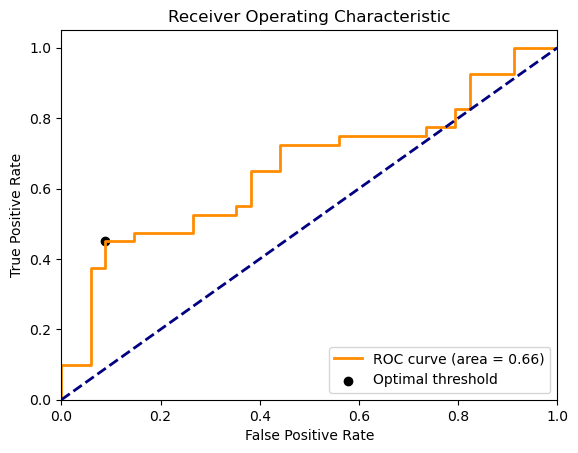

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have your model and test data ready
# X_test: test features
# y_test: true labels

# Get predicted probabilities
y_pred_prob = model_placement.predict(X_test_placement_reshaped).flatten()  # Assuming binary classification

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_placement, y_pred_prob)

# Compute the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold}')

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Optimal threshold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [16]:
import pickle
from sklearn.metrics import mean_squared_error, accuracy_score

# Assuming you have imported necessary libraries and defined tuner_cgpa, tuner_placement, X_train_cgpa_reshaped, y_train_cgpa, X_test_cgpa_reshaped, y_test_cgpa, X_train_placement_reshaped, y_train_placement, X_test_placement_reshaped, y_test_placement correctly

# Load the best hyperparameters for CGPA prediction
with open('best_hps_cgpa.pkl', 'rb') as f:
    best_hps_cgpa = pickle.load(f)

# Build and train the CGPA prediction model using the best hyperparameters
model_cgpa = tuner_cgpa.hypermodel.build(best_hps_cgpa)
model_cgpa.fit(X_train_cgpa_reshaped, y_train_cgpa, epochs=100, initial_epoch=10, validation_data=(X_test_cgpa_reshaped, y_test_cgpa))
# Assuming model_cgpa is defined and compiled correctly

# Print the shapes of X_test_cgpa_reshaped and y_test_cgpa
print('X_test_cgpa_reshaped shape:', X_test_cgpa_reshaped.shape)
print('y_test_cgpa shape:', y_test_cgpa.shape)

# Evaluate the model
evaluation_result = model_cgpa.evaluate(X_test_cgpa_reshaped, y_test_cgpa, verbose=0)
print('Evaluation result:', evaluation_result)

# Assuming evaluation_result is a float, you can access the MSE directly
mse_cgpa = evaluation_result
print('MSE for CGPA:', mse_cgpa)

# Load the best hyperparameters for placement prediction
with open('best_hps_placement.pkl', 'rb') as f:
    best_hps_placement = pickle.load(f)

# Build and train the placement prediction model using the best hyperparameters
model_placement = tuner_placement.hypermodel.build(best_hps_placement)
model_placement.fit(X_train_placement_reshaped, y_train_placement, epochs=100, initial_epoch=10, validation_data=(X_test_placement_reshaped, y_test_placement))
loss_placement, acc_placement = model_placement.evaluate(X_test_placement_reshaped, y_test_placement, verbose=0)
print('Accuracy for Placement:', acc_placement)


Epoch 11/100


/home/bhikrant07/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 47.9329 - val_loss: 12.2728
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 5.8723 - val_loss: 1.2183
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.7253 - val_loss: 1.1082
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.2424 - val_loss: 1.0117
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.3811 - val_loss: 0.9320
Epoch 16/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.3319 - val_loss: 0.9180
Epoch 17/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.1764 - val_loss: 0.8862
Epoch 18/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.5217 - val_loss: 0.8654
Epoch 19/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.3113 - val_loss: 0.8248
Epoch 20/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.3532 - val_loss: 0.8607
Epoch 21/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.1766 - val_loss: 0.8369
Epoch 22/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step -

/home/bhikrant07/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4844 - loss: 0.6948 - val_accuracy: 0.5541 - val_loss: 0.6917
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5503 - loss: 0.6918 - val_accuracy: 0.4324 - val_loss: 0.6938
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5446 - loss: 0.6922 - val_accuracy: 0.4324 - val_loss: 0.6978
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5190 - loss: 0.6909 - val_accuracy: 0.4459 - val_loss: 0.6932
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5468 - loss: 0.6906 - val_accuracy: 0.4730 - val_loss: 0.6910
Epoch 16/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5541 - loss: 0.6895 - val_accuracy: 0.4595 - val_loss: 0.6903
Epoch 17/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5452 - loss: 0.6900 - val_accuracy: 0.4730 - val_loss: 0.6925
Epoch 18/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5629 - loss: 0.6886 - val_accuracy: 0.4865 -

In [21]:


# Test the functions
print('X_test_processed_placement shape:', X_test_processed_placement.shape)
print(data.iloc[10]['CGPA after 8th semester'])
predict_student_cgpa(10)
print(data.iloc[10]['Cam_plc'])
predict_student_placement(10)

X_test_processed_cgpa shape: (74, 34)
X_test_processed_placement shape: (74, 35)
X_test_processed_placement shape: (74, 35)
9.13


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None